In [4]:
import sys
!{sys.executable} -m pip install pyreadr seaborn sklearn

In [18]:
import pickle
import pyreadr
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import scipy.stats as ss
import seaborn as sns
sns.set()
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
legend_fontsize = 14
ticks_fontsize = 18
figure_format = "pdf"
%matplotlib inline

In [6]:
# # below blocks are a poor attempt to recreate the necessary .pkl files for the load_data function later
# import gzip
# tpm_path= "./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
# f = gzip.open(tpm_path, 'rt')
# file_content = f.read()

In [7]:
# # f1 = open("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct", "w")
# # f1.write(file_content)
# # f1.close()

# # from cmapPy.pandasGEXpress.parse_gct import parse
# # tpm_data = parse(file_content)

# # from io import StringIO

# # s = str(file_content,'utf-8')
# # data = StringIO(s) 

# # much too slow
# tpm_data = pd.read_csv(data, delimiter='\t', skiprows=2)
# print(list(tpm_data.columns))

## Load metadata for samples and subjects in GTEx

In [19]:
# load sample metadata: 18220 samples, 73 technnical parameters
sampleMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt', sep = '\t', header = 'infer', index_col=0)
# load sample metadata: 948 people, 174 phenotipic parameters
subjectMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep = '\t', header = 'infer', index_col=0)

## Load data by tissue

In [20]:
def load_data(tissue):
    """ Load gene expression for each tissue.
    
     Parameters
    ----------
    tissue: one of GTEx tissues
    
     Outputs
    ----------
    data : pd.DataFrame
        genes x samples dataframe
    age : np.array, int
        age of each subject who provided the sample for the tissue
    SMRIN : np.array, float
        RIN number (RNA integrity number) for each sample
    SMTSISCH : np.array, int
        total ischemic time for each sample
    """
    
    print(tissue)
    data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/Expr_by_tissue/Expr_by_tissue/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm_"+\
    str(tissue)+".pkl"
    data = pd.read_pickle(data_p_file)
# TODO AAYUSH
#     # replace with RData ??
#     data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/GTEx_" + str(tissue) + ".RData"
#     data = pyreadr.read_r(data_p_file)
#     print(data.keys())
#     for key in data.keys():
#         print(data[key])
    
    gene_ids = data['Name']
    gene_names = data['Description']
    data.index = gene_ids
    data = data.iloc[:,2:]
    print(data.shape[1], " samples, ", data.shape[0], "genes")
    
    # filter out genes that are expressed in fewer than 10% of samples
    data = data[(data.T == 0).sum()<0.1*data.shape[1]]
    print(str(len((data.T == 0).sum()>0.1*data.shape[1])) + " genes filtered out")
    
    # filter out samples that express fewer than 10% of genes
    data = data.loc[:,data.columns[(pd.isna(data)).sum()<0.1*data.shape[0]]]
    print(str(len(data.columns[(pd.isna(data)).sum()>0.1*data.shape[0]])) + " samples filtered out")
    
    # load age, SNRIN, and SMTSUSCH values for each subject
    subject_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
     data.columns.tolist()]
    age = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subject_ids]
    SMRIN = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in data.columns.tolist()]
    SMTSISCH = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in data.columns.tolist()]
    return data, age, SMRIN, SMTSISCH

## Load and filter data

Choosing tissues that have > 800 samples (8 tissues in GTEx). It is arbitrary, so you can choose a lower threshold to study more tissues if your age prediciton model works even for fewer samples

In [21]:
# tissues = ['Muscle',
#  'Blood Vessel',
#  'Brain',
#  'Blood',
#  'Skin',
#  'Esophagus',
#  'Heart',
#  'Adipose Tissue']
tissues = ['Muscle', 'Blood Vessel']
# tissues = ['Muscle_Skeletal'] # Left over from sub tissue types 

In [22]:
data = {}
age = {}
SMRIN = {}
SMTSISCH = {}

for tissue in tissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)

Muscle
804  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
Blood Vessel
1335  samples,  56200 genes
21218 genes filtered out
0 samples filtered out


## Correct for covariates and remove outliers

### Find genes with weak correlation with age

In [23]:
def define_non_age_related_genes(data, age):
    rhos = np.zeros((len(data.index.tolist())))
    spear_pvals = np.zeros((len(data.index.tolist())))
    for i, gene in enumerate(data.index.tolist()):
        rhos[i], spear_pvals[i] = ss.spearmanr(data.loc[gene,:], age, nan_policy = 'omit')
    gene_idxs = range(data.shape[0])
    gene_idxs = [gene_idx for gene_idx in gene_idxs if spear_pvals[gene_idx]>0.01]
    print(str(len(gene_idxs)) + " genes with no correlation with age")
    non_aging_expr = data.iloc[gene_idxs,:]
    return(non_aging_expr)

### Perform SVD (singular value decomposition) of non-age related gene expression

In [24]:
def svd(non_aging_expr, n_comp = 50):
    u, s, vh  = np.linalg.svd(non_aging_expr.transpose())
    d2 = s**2
    print("first " + str(n_comp) + " components explain " + str(d2[:n_comp].sum()/d2.sum()) + " variability")
    print(u.shape)
    u_top_10 = u[:n_comp,:]
    x_0 = u_top_10*s
    return(x_0)

### Regress out non-age-related covariates

In [25]:
import sklearn.linear_model as linear_model
def linear_regression(x_train, y_train):
    ols = linear_model.LinearRegression()
    model = ols.fit(x_train, y_train)
    return ols.coef_, ols.intercept_, ols.predict(x_train)

def regress_covariates(data, x_0):
    coeffs, intercepts, prediction = linear_regression(x_0.transpose(), data.transpose()) 
    residual = (data.transpose()-np.asmatrix(x_0.transpose())*coeffs.transpose()).transpose()
    return residual

### Exclude non-age-related genes

In [26]:
def exclude_non_age_related_genes(residual, gene_idxs):
    aging_gene_idxs = [i for i in range(len(residual.index)) if i not in gene_idxs]
    residual_aging = residual.iloc[aging_gene_idxs,:]
    return(residual_aging)

### Remove outliers

In [16]:
def plot_PCA(X, ax, tissue):
    for i in range(len(X[:, 0])):
        ax.scatter(X[i, 0], X[i, 1], color = 'C0')
    ax.set_title(tissue, fontsize = title_fontsize)
    ax.set_xlabel('PC1', fontsize = xlabel_fontsize)
    ax.set_xlabel('PC2', fontsize = ylabel_fontsize)

In [17]:
from sklearn import decomposition
def detect_outliers(residual_aging, tissue):
    pca = decomposition.PCA(n_components=2)
    X = residual_aging.transpose().copy()
    pca.fit(X)
    X = pca.transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_PCA(X, ax, tissue)
    q1 = pd.DataFrame(X[:, 0]).quantile(0.999)
    q2 = pd.DataFrame(X[:, 1]).quantile(0.999)
    print(q1[0])
    print(q2[0])
    residual_no_outliers = residual_aging.iloc[:,np.asarray([j for j in \
                                                             range(len(residual_aging.columns)) \
                                                             if X[j, 0] < q1[0] and X[j, 1] < q2[0]])]
    print(str(residual_aging.shape[0] - residual_no_outliers.shape[0]) + " outliers removed")
    
    subj_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
                residual_no_outliers.columns.tolist()]
    ages = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subj_ids]
    SMRINs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    SMTSISCHs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    return residual_no_outliers, ages, SMRINs, SMTSISCHs

Muscle
9098 genes with no correlation with age
first 50 components explain 0.9998112297541029 variability
(803, 803)
66990.76865243462
76452.38636548584
0 outliers removed
Blood Vessel
8429 genes with no correlation with age
first 50 components explain 0.9984083167856995 variability
(1335, 1335)
103462.36856554556
24082.783351673548
0 outliers removed


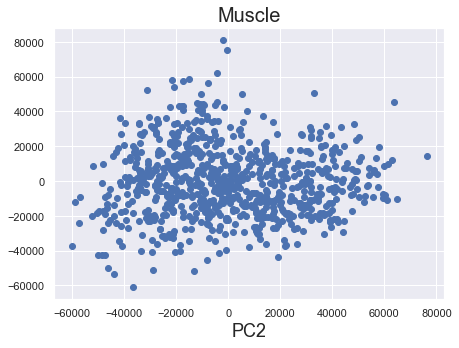

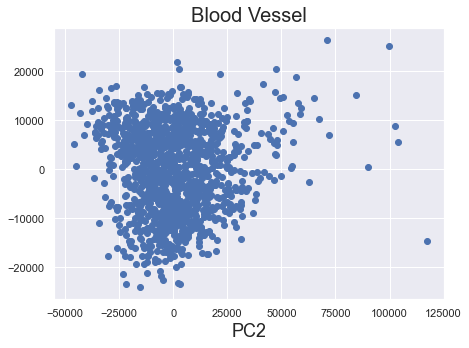

In [18]:
non_aging_expr = {}
x_0 = {}
residual = {}
residual_aging = {}
residual_no_outliers = {}
ages = {}
SMRINs = {}
SMTSISCHs = {}

for i, tissue in enumerate(tissues):
        print(tissue)
        
        non_aging_expr[tissue] = define_non_age_related_genes(data[tissue], age[tissue])
        x_0[tissue] = svd(non_aging_expr[tissue], n_comp=50)
        residual[tissue] = regress_covariates(data[tissue], x_0[tissue])
        residual_aging[tissue] = exclude_non_age_related_genes(residual[tissue], \
                                                               non_aging_expr[tissue].index.tolist())
        residual_no_outliers[tissue], ages[tissue], SMRINs[tissue], SMTSISCHs[tissue] = \
        detect_outliers(residual_aging[tissue], tissue)

## Build the model predicting age with Lasso

In [29]:
def split_train_valid_test(num_examples,training_proportion,validation_proportion,test_proportion):
    assert training_proportion<=1.0
    assert validation_proportion<=1.0
    assert test_proportion<=1.0
    assert (training_proportion+validation_proportion+test_proportion)<=1.0

    idx_shuff=np.random.RandomState(seed=77).permutation(range(num_examples))

    training_threshold=int(num_examples*training_proportion)
    validation_threshold=int(num_examples*(training_proportion+validation_proportion))

    training=range(training_threshold)
    validation=range(training_threshold,min(validation_threshold,num_examples))
    test=range(validation_threshold,num_examples)

    return(idx_shuff[list(training)],idx_shuff[list(validation)],idx_shuff[list(test)])

In [20]:
def fit_lasso_model(residual_no_outliers, ages, tol):
    """ Build an age predictor with the lasso model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tol : float, default=1e-4
        tolerance for the optimization in the lasso model
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # you can try a different model here
    reg = LassoCV(cv=5, random_state=0, tol = tol).fit(X, y)
    score = reg.score(X, y)
    
    # select genes predictive of age chosen by the lasso model
    genes = [residual_no_outliers.index[i] for i in range(residual_no_outliers.shape[0]) if reg.coef_[i]!=0]
    expr_sel_genes = residual_no_outliers.loc[genes,:]
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    coeffs_final, intercepts_final, prediction_final = \
    linear_regression(expr_sel_genes.iloc[:,train].transpose(), ages_train) 
    ages_pred_test = intercepts_final + \
    np.asmatrix(expr_sel_genes.iloc[:,test].transpose())*np.asmatrix(coeffs_final).transpose()
    ages_pred_test = [np.asarray(age)[0][0] for age in ages_pred_test]
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print(pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(genes, score, pearsonr, ages_test, ages_pred_test)


In [ ]:
import torch
class MLP(Module):
    # define model elements
    def __init__(self, n_genes, n_celltypes = 7):
        super(MLP, self).__init__()
        self.gene_to_hidden[n_celltypes] = [Linear(n_genes, 100) for i in range(n_celltypes)]
        self.hidden_to_hidden2 = Linear(100, 100)
        self.hidden2_to_hidden3 = Linear(n_genes, 100)
        self.hidden3_to_age = Linear(n_genes, 100)
        self.activation = ReLU()
        self.n_celltypes = n_celltypes
        self.n_genes = n_genes
    # forward propagate input

    def forward(self, X, freq):
        """
            X - 2d matrix of shape: patients x (n_genes x n_celltypes)
            freq - 2d matrix of shape: patients x n_celltypes
        """
        assert(X.shape[1] == self.n_genes * self.n_celltypes)
        assert(freq.shape[1] == self.n_celltypes)
        assert(X.shape[0] == freq.shape[0])
        layer2 = X[:, 0:]
        X[:, 0:] = self.gene_to_hidden[0](X[:, 0:])
        X = self.activation(X)
        return X

In [78]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

def fit_mlp_model(residual_no_outliers, ages, tissue, alpha=0.001, epochs=200):
    """ Build an age predictor with the lasso model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tissue : string
        name of the tissue
    alpha: int
        lr
    epochs: int
        epochs 
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    
    x_train = residual_no_outliers.iloc[:,train].transpose()
    x_test = residual_no_outliers.iloc[:,test].transpose()
    print("data done")

    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    print(x_train.shape, x_test.shape, ages_train.shape)
    
    # print("Training lin reg")
    # model = LinearRegression()
    # reg = model.fit(x_train, ages_train)
    # print("Finished training lin reg")

    # you can try a different model here
    print("Training neural net")
    model = MLPRegressor(hidden_layer_sizes=(1000, 500, 100, 100), max_iter=epochs, verbose=True, alpha=alpha, lr="adaptive", learning_rate_init=0.001)
    reg = model.fit(x_train, ages_train)
    print("Finished training neural net")

    # previously trained on lasso
    # reg = LassoCV(cv=5, random_state=0, tol = tol).fit(X, y)
    score = reg.score(x_test, ages_test)
    print("Predicted: ", reg.predict(x_test))
    print("Tested")
    
    
    # save the model to disk
    filename = 'mlp250_' + "_".join(tissue.split(" ")) + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    # select genes predictive of age chosen by the lasso model
    # removed to just select all genes
    # genes = [residual_no_outliers.index[i] for i in range(residual_no_outliers.shape[0])] # if reg.coef_[i]!=0]
    # expr_sel_genes = residual_no_outliers.loc[genes,:]
    
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    # coeffs_final, intercepts_final, prediction_final = \
    # linear_regression(expr_sel_genes.iloc[:,train].transpose(), ages_train) 
    # ages_pred_test = intercepts_final + \
    # np.asmatrix(expr_sel_genes.iloc[:,test].transpose())*np.asmatrix(coeffs_final).transpose()
    
    # set ages pred test to prediction
    ages_pred_test = reg.predict(x_test)
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print("Pearson r: ", pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(score, pearsonr, ages_test, ages_pred_test)

In [79]:
# This section checks for the MLP training on the whole data, with attempting to learn one data point
from pandas import DataFrame as df
genes_clock = {}
score = {}
pearson_corr = {}
prediction = {}
true = {}

newAges = {}
for i, tissue in enumerate(tissues[:2]):
    print(type(age[tissue]))
    newAges[tissue] = age[tissue]
    print(data[tissue].T.iloc[:1].T)
    print(age[tissue][0:2])
    print(df(age[tissue], columns=["Age"]))

    # Do if the ages are bucketed only
    # newAges[tissue] = [int(age[:2]) + 5 for age in ages[tissue]]
    score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_mlp_model(data[tissue].T.iloc[0:2].T, age[tissue][0:2], tissue, 0, 30)
    #mlpregressor
    #mlp classifier - 3.75

<class 'list'>
                    GTEX-1117F-0426-SM-5EGHI
Name                                        
ENSG00000182890.4                    0.28300
ENSG00000234176.1                    0.17960
ENSG00000125675.17                   0.02902
ENSG00000125676.19                   9.89900
ENSG00000101966.12                   7.19800
...                                      ...
ENSG00000177054.13                   3.09500
ENSG00000129170.8                   97.90000
ENSG00000129173.12                   1.03600
ENSG00000166833.19                   5.58100
ENSG00000270607.1                    0.33480

[19544 rows x 1 columns]
[66, 57]
     Age
0     66
1     57
2     61
3     63
4     62
..   ...
798   66
799   67
800   24
801   53
802   50

[803 rows x 1 columns]
data done
(1, 19544) (1, 19544) (1,)
Training neural net
Iteration 1, loss = 6192.26920821
Iteration 2, loss = 5349683.90568376
Iteration 3, loss = 537580.83570579
Iteration 4, loss = 679679.94391749
Iteration 5, loss = 96356.6332714

ValueError: x and y must have length at least 2.

In [ ]:
# This section checks for the MLP training on the whole data, with a train/test split
genes_clock = {}
score = {}
pearson_corr = {}
prediction = {}
true = {}

newAges = {}
for i, tissue in enumerate(tissues[:2]):
    print(tissue)
    newAges[tissue] = age[tissue]

    # Do if the ages are bucketed only
    # newAges[tissue] = [int(age[:2]) + 5 for age in ages[tissue]]
    score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_mlp_model(data[tissue], age[tissue], tissue, 0.0001)
    #mlpregressor
    #mlp classifier - 3.75

In [13]:
genes_clock = {}
score = {}
pearson_corr = {}
prediction = {}
true = {}

newAges = {}
for i, tissue in enumerate(tissues[:2]):
    print(tissue)
    # newAges[tissue] = age[tissue]
    print(data, age)
    # newAges[tissue] = [int(age[:2]) + 5 for age in ages[tissue]]
    score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_mlp_model(data[tissue], age[tissue], tissue, 0.001)

    score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
    fit_mlp_model(data[tissue], age[tissue], tissue, 0.01)

Muscle
{} {}


KeyError: 'Muscle'

# Additional analysis

### Comparing prediction accuracy for different tissues

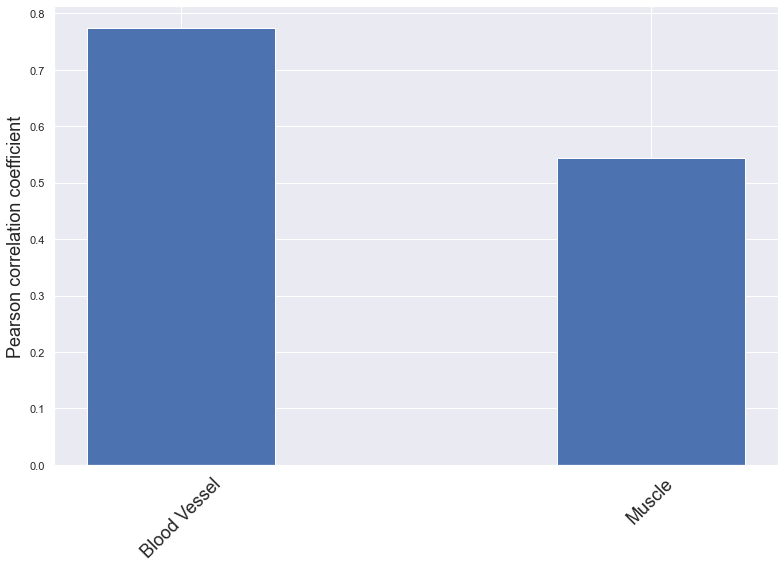

In [20]:
fig, ax = plt.subplots(figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize) 
plt.tight_layout()
pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

## Define most important covariates
These could be included in the model or regressed out to improve age prediction

In [21]:
def gaussian_project(data, standardize=True, noise=1e-6):
    """ Project each row onto gaussian with matched mean, stdev 

    standardize : bool
        project each row onto N(0, 1), otherwise use N(mu_row, sigma_row),
        where mu_row is the mean of the row and sigma_row is the standard
        deviation
    noise : float
        add random noise drawn from interval (0, noise) to break ties
    """
    # add random noise to break ties
    err = np.random.random(data.shape) * noise
    data = data + err

    ppt = data.rank(axis=1) / (float(data.shape[1])+1.)
    if standardize:
        df = pd.DataFrame(ss.norm.ppf(ppt), index=ppt.index, 
                          columns=ppt.columns)
    else:
        mu = data.mean(axis=1)
        sigma = data.std(axis=1)
        df = {}
        for r in ppt.index:
            df[r] = pd.Series(ss.norm.ppf(ppt.loc[r], loc=mu.loc[r],
                                          scale=sigma.loc[r]), index=ppt.columns)
        df = pd.DataFrame(df).T
    return df
def find_covars_corr_with_first_2_pcs(tissue, data, ax):
        dt = data.copy()
        dt_g = gaussian_project(dt)

        assert(np.sort(np.std(dt_g))[0] > 0)
        print(dt_g.shape)
        assert(dt_g.equals(dt_g.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()))
        u, s, vh = np.linalg.svd(dt_g)
        # print(s)
        print(np.sort(s))
        u, s, vh = np.linalg.svd(dt_g[:-1, :])
        # print(s)
        print(np.sort(s))
        pca = PCA().fit(dt_g)

        # extract principal components
        comps = pd.DataFrame(pca.components_.T, index=dt_g.columns,
                             columns=['PC%i' % (i+1) for i in range(len(pca.components_))])
        
        # choose potential important covariates (add whatever you are interesred in)
        covars = ['SMRIN', 'SMTSISCH', 'TRISCHD', 'ETHNCTY', 'RACE', 'AGE', 'BMI', 'SMNTRNRT', 'DTHRFG', 'DTHVNT', \
                  'SMATSSCR', 'SMALTALG', 'DTHHRDY', 'DTHHRDY']
        print('components', pca.explained_variance_ratio_[0:10])
    
        if np.fabs(sum(pca.explained_variance_ratio_)-1)>0.1:
            print('sum', sum(pca.explained_variance_ratio_))
        
        covs_r = {}
        covs_p = {}
        for pc in ['PC{}'.format(i+1) for i in range(10)]:
            _r = {}
            _p = {}
            for cv in covars:
                if cv in sampleMetaData.columns:
                    covar_vals = np.asarray(sampleMetaData.loc[comps.index, cv])
                elif cv in subjectMetaData.columns:
                    sample_subject_ids = [index.split("-")[0] + "-" + index.split("-")[1] \
                                 for index in list(comps.index)]
                    covar_vals = np.asarray(subjectMetaData.loc[sample_subject_ids, cv])
                _r[cv], _p[cv] = ss.pearsonr(covar_vals[np.isfinite(covar_vals)], \
                                             comps.loc[np.isfinite(covar_vals), pc])
                covs_r[pc] = pd.Series(_r)
                covs_p[pc] = pd.Series(_p)
        covs_r = pd.DataFrame(covs_r).loc[:, ['PC{}'.format(i+1) for i in range(10)]]
        covs_p = pd.DataFrame(covs_p).loc[:, ['PC{}'.format(i+1) for i in range(10)]]

        covarsMain = [covar for covar in covars if (covs_p.loc[covar,:][0:10]<0.05).any()==True]
        first_2_pcs_pars = [covar for covar in covars if (covs_p.loc[covar,:][0:2]<0.05).any()==True]
        ax.set_title(tissue)
        sns.heatmap(-1*np.log10(covs_p.loc[covarsMain,:]), ax=ax, vmax=10, annot=True, fmt=".1f")
        return(first_2_pcs_pars)

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Muscle', data['Muscle'], ax)  

(19544, 803)
[9.05601909e-13 4.36335506e+01 4.39621839e+01 4.42601923e+01
 4.44999937e+01 4.45597220e+01 4.46664282e+01 4.48649943e+01
 4.48762186e+01 4.50134032e+01 4.52276521e+01 4.53553313e+01
 4.54064525e+01 4.56036780e+01 4.56951238e+01 4.58022107e+01
 4.58607788e+01 4.59451523e+01 4.59953202e+01 4.61465383e+01
 4.62034389e+01 4.62536154e+01 4.63256471e+01 4.63418548e+01
 4.65024007e+01 4.65627920e+01 4.66544893e+01 4.67424204e+01
 4.67455056e+01 4.69101474e+01 4.69750788e+01 4.70920029e+01
 4.71652702e+01 4.72191861e+01 4.72492772e+01 4.72996223e+01
 4.73562242e+01 4.74393000e+01 4.74873122e+01 4.75353263e+01
 4.76217924e+01 4.76534862e+01 4.77784131e+01 4.78156295e+01
 4.78611523e+01 4.79572079e+01 4.79850920e+01 4.80209695e+01
 4.80740602e+01 4.81483873e+01 4.81893921e+01 4.82542266e+01
 4.83665537e+01 4.84255003e+01 4.84586248e+01 4.84801800e+01
 4.85211515e+01 4.85857892e+01 4.86326768e+01 4.87297020e+01
 4.87419651e+01 4.88722264e+01 4.89007597e+01 4.89468375e+01
 4.89706734

TypeError: '(slice(None, -1, None), slice(None, None, None))' is an invalid key

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Esophagus', data['Esophagus'], ax)

## Color PCA by parameter (age, RNA quality, ischemic time before) values to explore important parameters for each tissue

You can look at other technical or phenotypic covariates to find those that can possibly explain PCA patterns for tissues that clearly have clusters: skin and esophagus

In [ ]:
def plot_pca_colored_by(data, parameter):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    pca = decomposition.PCA(n_components=2)
    X = data.transpose().copy()
    pca.fit(X)
    y = np.asarray(parameter)
    X = pca.transform(X)
    y_no_na = y[np.where(np.isfinite(y))]
    y_min = np.min(y_no_na)
    y_max = np.max(y_no_na)
    
    for i in range(len(X[:, 0])):
        if np.isfinite(y[i]):
            alpha = float((y[i]-y_min)/float(y_max-y_min))
            ax.scatter(X[i, 0], X[i, 1], color = 'green', alpha = alpha, s=15)

In [ ]:
plot_pca_colored_by(residual_no_outliers["Esophagus"], SMTSISCH["Esophagus"])

## Sample size of each tissue
I chose top 8 tissues for the analysis above

In [ ]:
# tissues = list(set(sampleMetaData['SMTS']))
# sample_num = dict()
# for tissue in tissues:
#         data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)
#         sample_num[tissue] = data[tissue].shape[1]
# out_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(sample_num,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
sample_num = pd.read_pickle("/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl")
tissues = list(sample_num.keys())
sample_numbers = np.asarray([sample_num[tissue] for tissue in tissues])
indices = np.argsort(sample_numbers)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(range(len(tissues)), sample_numbers[indices])
ax.set_xticks(range(len(tissues)))
ax.set_xticklabels([tissues[index] for index in indices], rotation = 90)

## Plot sample age distribution for each tissue
Most samples are from elderly since they die more often

In [ ]:
for tissue in tissues:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(age[tissue])
    ax.set_title(tissue, fontsize=title_fontsize)